<>:6: SyntaxWarning: invalid escape sequence '\('
<>:6: SyntaxWarning: invalid escape sequence '\('
/var/folders/nr/fsdjxt490mg3r9b88wh_nnph0000gn/T/ipykernel_54911/2124425867.py:6: SyntaxWarning: invalid escape sequence '\('
  """


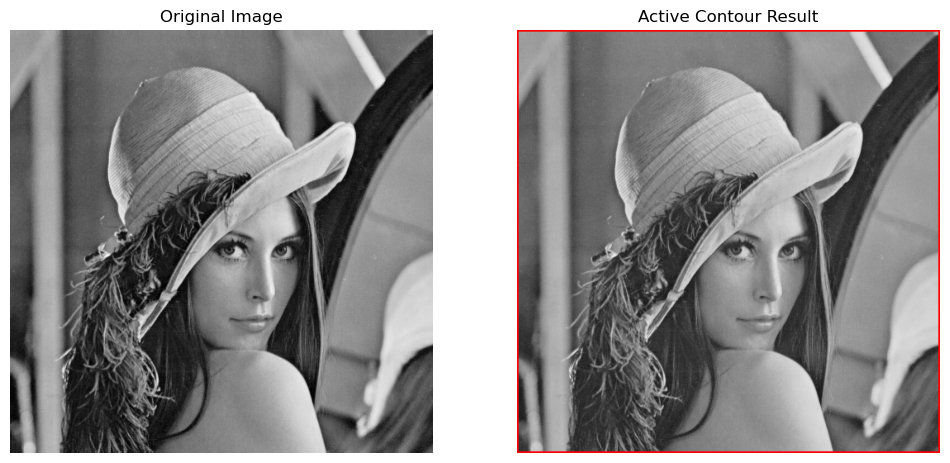

In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def compute_energy(image, g, alpha=1.0, beta=1.0, gamma=1.0):
    """
    에너지 함수 \( E^*(g(s)) \) 계산
    """
    n = len(g)
    E_total = 0.0

    for s in range(n):
        # 연속성 에너지 (E_continuity)
        ds = 1 if s < n-1 else -(n-1)  # 주기적 경계 조건
        E_continuity = alpha * np.linalg.norm(g[s] - g[(s + ds) % n])

        # 곡률 에너지 (E_curvature)
        s_prev = (s - 1) % n
        s_next = (s + 1) % n
        E_curvature = beta * np.linalg.norm(g[s_prev] - 2 * g[s] + g[s_next])**2

        # 이미지 에너지 (E_image)
        min_val = image.min()
        max_val = image.max()
        E_image = gamma * (min_val - max_val) / (max_val - min_val + 1e-10)  # 안정성 위해 작은 값 추가

        E_total += E_continuity + E_curvature + E_image

    return E_total / n

def update_snake(image, g, alpha=1.0, beta=1.0, gamma=1.0, step_size=0.1, max_iter=100):
    """
    스네이크 알고리즘으로 곡선 업데이트
    """
    n = len(g)
    moved = False
    iterations = 0

    # 이미지 경사 계산
    grad_y, grad_x = np.gradient(image)  # grad_y: y 방향 경사, grad_x: x 방향 경사

    while True:
        moved = False
        new_g = g.copy()

        for s in range(n):
            # 경사 계산 (에너지 최소화 방향)
            s_prev = (s - 1) % n
            s_next = (s + 1) % n

            # 연속성 항의 기울기
            ds = 1 if s < n-1 else -(n-1)
            grad_continuity = alpha * (g[(s + ds) % n] - g[s])

            # 곡률 항의 기울기 (2차 미분 근사)
            grad_curvature = beta * (g[s_prev] - 2 * g[s] + g[s_next])

            # 이미지 에너지 (경계 강도를 기반으로)
            x, y = g[s].astype(int)
            grad_image = np.array([grad_x[y, x], grad_y[y, x]]) * gamma  # x, y 방향 경사를 별도로 추출

            # 총 기울기
            grad = grad_continuity + grad_curvature - grad_image  # 에너지 최소화
            new_g[s] -= step_size * grad

            # 경계 내로 제한
            new_g[s] = np.clip(new_g[s], 0, [image.shape[1]-1, image.shape[0]-1])

            if np.linalg.norm(new_g[s] - g[s]) > 1e-3:
                moved = True

        g = new_g
        iterations += 1

        if not moved or iterations >= max_iter:
            break

    return g

def apply_active_contour(image_path, initial_contour, T1=1.0, T2=0.1, T3=50):
    """
    활성 윤곽선(Active Contour) 알고리즘 적용
    """
    # 이미지 불러오기
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    if image is None:
        print(f"이미지를 불러올 수 없습니다. 경로를 확인하세요: {image_path}")
        return None, None

    # 초기 곡선 설정
    g = np.array(initial_contour, dtype=np.float32)

    # 에지 맵 생성 (Canny 에지 검출)
    edges = cv2.Canny(image, T2 * 255, T3 * 255)
    edge_map = edges.astype(float) / 255.0

    # 스네이크 업데이트
    g_final = update_snake(edge_map, g, alpha=1.0, beta=1.0, gamma=1.0, step_size=0.1, max_iter=100)

    # 결과 시각화
    result_image = cv2.cvtColor(image, cv2.COLOR_GRAY2BGR)
    for i in range(len(g_final)):
        cv2.line(result_image, tuple(g_final[i].astype(int)), tuple(g_final[(i+1) % len(g_final)].astype(int)), (0, 0, 255), 2)

    return image, result_image

# 시각화
if __name__ == "__main__":
    # 이미지 파일 경로 설정
    image_path = "./image/lena.bmp"  # 실제 이미지 경로로 대체

    # 초기 곡선 (예: 이미지 중앙의 사각형)
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    if image is None:
        print("이미지를 로드할 수 없습니다. 경로를 확인하세요.")
    else:
        height, width = image.shape
        initial_contour = np.array([
            [width//4, height//4],
            [3*width//4, height//4],
            [3*width//4, 3*height//4],
            [width//4, 3*height//4]
        ], dtype=np.float32)

        # Active Contour 적용
        original_image, segmented_image = apply_active_contour(image_path, initial_contour, T1=1.0, T2=0.1, T3=50)

        if original_image is not None and segmented_image is not None:
            plt.figure(figsize=(12, 6))

            plt.subplot(121)
            plt.imshow(original_image, cmap='gray')
            plt.title("Original Image")
            plt.axis('off')

            plt.subplot(122)
            plt.imshow(cv2.cvtColor(segmented_image, cv2.COLOR_BGR2RGB))
            plt.title("Active Contour Result")
            plt.axis('off')

            plt.show()
